In [ ]:
!pip -q install torch torchvision
!pip -q install transformers datasets
!pip -q install transformers[torch]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# PyTorch
import torch
import torchvision
from torchvision.transforms import Normalize, Resize, ToTensor, Compose
# For dislaying images
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
# Loading dataset
from datasets import load_dataset
# Transformers
from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import TrainingArguments, Trainer
# Matrix operations
import numpy as np
# Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:

#Only a small subset of dataset is used for demonstration purpose. Split the data into training, validation and testing datasets
trainds, testds = load_dataset("cifar10", split=["train[:5000]","test[:1000]"])
splits = trainds.train_test_split(test_size=0.1)
trainds = splits['train']
valds = splits['test']
trainds, valds, testds

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

(Dataset({
     features: ['img', 'label'],
     num_rows: 4500
 }),
 Dataset({
     features: ['img', 'label'],
     num_rows: 500
 }),
 Dataset({
     features: ['img', 'label'],
     num_rows: 1000
 }))

In [ ]:
trainds.features, trainds.num_rows, trainds[0]

({'img': Image(mode=None, decode=True, id=None),
  'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)},
 4500,
 {'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  'label': 5})

In [ ]:
#Now let’s map the integer labels to string labels and vice-versa.
itos = dict((k,v) for k,v in enumerate(trainds.features['label'].names))
stoi = dict((v,k) for k,v in enumerate(trainds.features['label'].names))
itos

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

dog


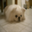

In [ ]:
#Now, let’s display an image and corresponding label from the dataset.
index = 0
img, lab = trainds[index]['img'], itos[trainds[index]['label']]
print(lab)
img

In [ ]:
#Now, let’s do some Image processing using Hugging Face and PyTorch.
#We use ViTImageProcessor to handle Image-to-patch conversion (image Tokenizer) and normalization.
model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)

mu, sigma = processor.image_mean, processor.image_std #get default mu,sigma
size = processor.size

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
norm = Normalize(mean=mu, std=sigma) #normalize image pixels range to [-1,1]

# resize 3x32x32 to 3x224x224 -> convert to Pytorch tensor -> normalize
_transf = Compose([
    Resize(size['height']),
    ToTensor(),
    norm
])

# apply transforms to PIL Image and store it to 'pixels' key
def transf(arg):
    arg['pixels'] = [_transf(image.convert('RGB')) for image in arg['img']]
    return arg

In [ ]:
#Apply the transformations to each dataset.
trainds.set_transform(transf)
valds.set_transform(transf)
testds.set_transform(transf)

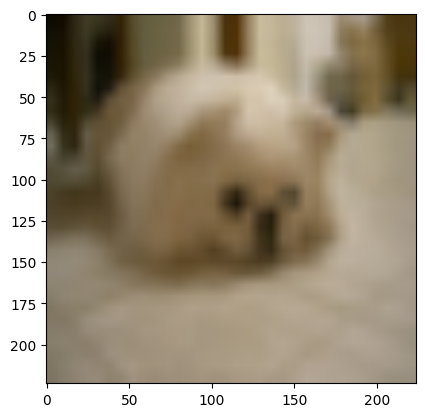

In [ ]:
#To view a transformed image, run the following code snippet
idx = 0
ex = trainds[idx]['pixels']
ex = (ex+1)/2 #imshow requires image pixels to be in the range [0,1]
exi = ToPILImage()(ex)
plt.imshow(exi)
plt.show()

In [ ]:
#We use Hugging Face’s ViTForImageClassification which takes images as input and outputs the predictions of classes.
#Let’s first see what the original model’s classifier looks like.
model_name = "google/vit-base-patch16-224"
model = ViTForImageClassification.from_pretrained(model_name)
print(model.classifier)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Linear(in_features=768, out_features=1000, bias=True)


In [ ]:
"""
It outputs probabilities for 1000 classes as it should because it was originally fine-tuned on ImageNet-1k.

We can fine tune it to output 10 classes using the following parameters: num_labels which basically changes the number of nodes in final linear layer,
ignore_mismatched_sizes because originally it would have 1000 output nodes but now we’ll just have 10, and the mapping of label indices and label strings.
"""

'\nIt outputs probabilities for 1000 classes as it should because it was originally fine-tuned on ImageNet-1k.\n\nWe can fine tune it to output 10 classes using the following parameters: num_labels which basically changes the number of nodes in final linear layer, \nignore_mismatched_sizes because originally it would have 1000 output nodes but now we’ll just have 10, and the mapping of label indices and label strings.\n'

In [ ]:
model = ViTForImageClassification.from_pretrained(model_name, num_labels=10, ignore_mismatched_sizes=True, id2label=itos, label2id=stoi)
print(model.classifier)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=768, out_features=10, bias=True)


In [ ]:
"""
Trainer provides a high level of abstraction and simplifies the training and evaluation.

Let’s start of with training arguments where you can define hyperparameters, logging, metrics, etc.
"""
args = TrainingArguments(
    f"test-cifar-10",
    save_strategy="epoch",
    # Replaced 'evaluation_strategy' with 'eval_strategy'
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='logs',
    remove_unused_columns=False,
)


In [ ]:
"""
Now, we need a collate function that is used in data loading. It stacks pixel values into a tensor and creates a tensor for labels. The model needs pixel_values and labels in a batch of inputs so do not change the names of these tensors.

We also need a function to compute metrics. In our case, we’ll use accuracy. I recommend passing a sample input into these functions and printing the values to better understand them.
"""

'\nNow, we need a collate function that is used in data loading. It stacks pixel values into a tensor and creates a tensor for labels. The model needs pixel_values and labels in a batch of inputs so do not change the names of these tensors.\n\nWe also need a function to compute metrics. In our case, we’ll use accuracy. I recommend passing a sample input into these functions and printing the values to better understand them.\n'

In [ ]:
def collate_fn(examples):
    pixels = torch.stack([example["pixels"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixels, "labels": labels}

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=trainds,
    eval_dataset=valds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

<ipython-input-17-af63251bbd46>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
"""
We have to train the last layer that we fine-tuned while keeping all other layers freezed. Do this by simply calling:
"""

trainer.train()


"""

5cad00af373791f4dec51990688c36eb571934a7

"""

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kayadeniz2001 (kayadeniz2001-maastricht-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.078446,0.980000
2,0.365000,0.093994,0.974000
3,0.014200,0.069063,0.984000


'\n\n5cad00af373791f4dec51990688c36eb571934a7\n\n'

In [ ]:
outputs = trainer.predict(testds)
print(outputs.metrics)

{'test_loss': 0.05342692509293556, 'test_accuracy': 0.982, 'test_runtime': 4.4954, 'test_samples_per_second': 222.448, 'test_steps_per_second': 55.612}


In [ ]:
itos[np.argmax(outputs.predictions[0])], itos[outputs.label_ids[0]]

('cat', 'cat')

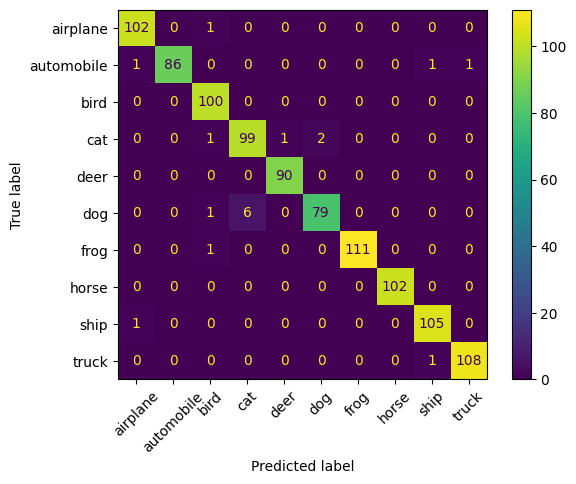

In [ ]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = trainds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [ ]:
!ls test-cifar-10

checkpoint-1350  checkpoint-450  checkpoint-900


In [ ]:
from transformers import ViTForImageClassification, ViTImageProcessor
import torch

# Model ve processor’ı yükle
model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)

# Load the model from the local directory
model = ViTForImageClassification.from_pretrained(
    "test-cifar-10/checkpoint-1350",  # Path to your locally saved model
    num_labels=10,
    ignore_mismatched_sizes=True,
    local_files_only=True  # This tells the function to only look for local files
)

model.to('cpu')  # Modeli CPU’ya taşı
model.eval()  # Inference için eval moduna geçir
print("Model loaded on CPU!!")

Model loaded on CPU!!


In [ ]:
!ls -l test-cifar-10/checkpoint-1350

total 1005780
-rw-r--r-- 1 root root       992 May 10 15:00 config.json
-rw-r--r-- 1 root root 343248584 May 10 15:00 model.safetensors
-rw-r--r-- 1 root root 686618042 May 10 15:00 optimizer.pt
-rw-r--r-- 1 root root       351 May 10 15:00 preprocessor_config.json
-rw-r--r-- 1 root root     14244 May 10 15:00 rng_state.pth
-rw-r--r-- 1 root root      1064 May 10 15:00 scheduler.pt
-rw-r--r-- 1 root root      1832 May 10 15:00 trainer_state.json
-rw-r--r-- 1 root root      5304 May 10 15:00 training_args.bin


In [ ]:
from transformers import ViTForImageClassification, ViTImageProcessor
import torch

# Model ve processor’ı yükle
model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)

# Checkpoint’ten modeli yükle
model = ViTForImageClassification.from_pretrained(
    "test-cifar-10/checkpoint-1350",  # Doğru checkpoint dizini
    num_labels=10,
    ignore_mismatched_sizes=True
)

model.to('cpu')  # Modeli CPU’ya taşı
model.eval()  # Inference için eval moduna geçir
print("Model CPU’da yüklendi!")

Model CPU’da yüklendi!


In [ ]:
from datasets import load_dataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# Test veri setinden bir görüntü al
testds = load_dataset("cifar10", split="test[:1000]")
sample_image = testds[0]['img']
itos = dict((k, v) for k, v in enumerate(testds.features['label'].names))

# Görüntüyü işle
transform = Compose([
    Resize(224),
    ToTensor(),
    Normalize(mean=processor.image_mean, std=processor.image_std)
])
pixel_values = transform(sample_image.convert('RGB')).unsqueeze(0).to('cpu')

# Tahmin yap
with torch.no_grad():
    outputs = model(pixel_values)
predicted_class = outputs.logits.argmax(-1).item()
print(f"Predicted class: {itos[predicted_class]}")
print(f"Actual class: {itos[testds[0]['label']]}")

Predicted class: cat
Actual class: cat


In [ ]:
from datasets import load_dataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import torch
import numpy as np
import time

# Veri setini yükle
testds = load_dataset("cifar10", split="test[:1000]")
itos = dict((k, v) for k, v in enumerate(testds.features['label'].names))

# Preprocessing
transform = Compose([
    Resize(224),
    ToTensor(),
    Normalize(mean=processor.image_mean, std=processor.image_std)
])

# Inference döngüsü
start_time = time.time()
predictions = []
true_labels = []
for example in testds:
    image = example['img']
    label = example['label']
    pixel_values = transform(image.convert('RGB')).unsqueeze(0).to('cpu')
    with torch.no_grad():
        outputs = model(pixel_values)
    pred = outputs.logits.argmax(-1).item()
    predictions.append(pred)
    true_labels.append(label)

# Metrikler
accuracy = np.mean(np.array(predictions) == np.array(true_labels))
inference_time = time.time() - start_time

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Total Inference Time (CPU): {inference_time:.2f} seconds")
print(f"Average Inference Time per Image: {inference_time / len(testds):.4f} seconds")
print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")

Test Accuracy: 0.9820
Total Inference Time (CPU): 97.88 seconds
Average Inference Time per Image: 0.0979 seconds
Model Parameters: 85,806,346


In [ ]:
%%writefile inference.py
import torch
import argparse
from transformers import ViTImageProcessor, ViTForImageClassification
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from datasets import load_dataset
import numpy as np
import time

def load_model(checkpoint_path):
    model_name = "google/vit-base-patch16-224"
    processor = ViTImageProcessor.from_pretrained(model_name)
    model = ViTForImageClassification.from_pretrained(
        checkpoint_path,
        num_labels=10,
        ignore_mismatched_sizes=True
    )
    model.to('cpu')
    model.eval()
    return model, processor

def inference(image, model, processor):
    transform = Compose([
        Resize(224),
        ToTensor(),
        Normalize(mean=processor.image_mean, std=processor.image_std)
    ])
    pixel_values = transform(image.convert('RGB')).unsqueeze(0).to('cpu')
    with torch.no_grad():
        outputs = model(pixel_values)
    return outputs.logits.argmax(-1).item()

def main():
    parser = argparse.ArgumentParser(description="Inference on CIFAR-10")
    parser.add_argument("--checkpoint", required=True, help="Path to model checkpoint")
    args = parser.parse_args()

    # Modeli yükle
    model, processor = load_model(args.checkpoint)

    # Veri setini yükle
    testds = load_dataset("cifar10", split="test[:1000]")
    itos = dict((k, v) for k, v in enumerate(testds.features['label'].names))

    # Inference
    start_time = time.time()
    predictions = []
    true_labels = []
    for example in testds:
        image = example['img']
        label = example['label']
        pred = inference(image, model, processor)
        predictions.append(pred)
        true_labels.append(label)

    # Metrikler
    accuracy = np.mean(np.array(predictions) == np.array(true_labels))
    inference_time = time.time() - start_time
    param_count = sum(p.numel() for p in model.parameters())

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Total Inference Time (CPU): {inference_time:.2f} seconds")
    print(f"Average Inference Time per Image: {inference_time / len(testds):.4f} seconds")
    print(f"Model Parameters: {param_count:,}")

if __name__ == "__main__":
    main()

Writing inference.py


In [ ]:
from google.colab import files
!zip -r checkpoint-1350.zip test-cifar-10/checkpoint-1350
files.download("checkpoint-1350.zip")

  adding: test-cifar-10/checkpoint-1350/ (stored 0%)
  adding: test-cifar-10/checkpoint-1350/config.json (deflated 53%)
  adding: test-cifar-10/checkpoint-1350/rng_state.pth (deflated 25%)
  adding: test-cifar-10/checkpoint-1350/model.safetensors (deflated 7%)
  adding: test-cifar-10/checkpoint-1350/training_args.bin (deflated 52%)
  adding: test-cifar-10/checkpoint-1350/optimizer.pt (deflated 8%)
  adding: test-cifar-10/checkpoint-1350/trainer_state.json (deflated 65%)
  adding: test-cifar-10/checkpoint-1350/preprocessor_config.json (deflated 47%)
  adding: test-cifar-10/checkpoint-1350/scheduler.pt (deflated 56%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>